Project: Prevent Generative AI from Learning with Adversarial Attacks <br>
Description: Compare the generation of images using GANs trained with original and adversarial data <br>
Author: Thomas Fiello

In [1]:
from __future__ import print_function
import os
import argparse
import random
import torch
import torchvision
import torch.nn as nn
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import HTML
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Random Seed:  42


In [2]:
# If training from scratch, set to True
train = True

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 64

# Number of channels in the training images. For color images this is 3
n_channels = 3

# Size of z latent vector (i.e. size of generator input)
z_vector = 100

# Size of feature maps in generator
f_map_g = 64

# Size of feature maps in discriminator
f_map_d = 64

# Learning rate for optimizers
l_rate = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
n_gpu = 1

# Number of classes.
n_class = 51

# Root directory of dataset location
root = 'C:/Users/tfiel/Documents/Python Scripts/CS595A/datasets'

In [3]:
# Makes sure that we have a directory of clean and adversarial images
dir = root + '/test_data/images/adversarial_images'

img_name = []
for path, subdirs, files in os.walk(dir):
    for name in files:
        img_name.append(name)
dir = root + '/test_data/images/clean_images'
for path, subdirs, files in os.walk(dir):
    for name in files:
        if name not in img_name:
            img_path = (path+'/'+name).replace("\\", "/")
            os.remove(img_path)

In [4]:
data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
        ])

if train == True:
    # Define the data directory and the data transforms
    data_dir = root + '/top_artists/images/'

    # Load the dataset using ImageFolder
    top_artists = datasets.ImageFolder(data_dir, transform=data_transforms)
    n_class = len(top_artists.class_to_idx)

    clean_dir = root + '/test_data/images/clean_images'
    # Load the dataset using ImageFolder
    clean_imgs = datasets.ImageFolder(clean_dir, transform=data_transforms)
    clean_imgs = torch.utils.data.Subset(clean_imgs, range(249))

    adv_dir = root + '/test_data/images/adversarial_images'
    # Load the dataset using ImageFolder
    adv_imgs = datasets.ImageFolder(adv_dir, transform=data_transforms)
    adv_imgs = torch.utils.data.Subset(adv_imgs, range(249))

In [5]:
if train == True:
    #train_set, test_set = train_test_split(top_artists, random_state=0, test_size=0.3)

    # Create a data loader for the dataset
    Dtr = DataLoader(top_artists, batch_size=batch_size, shuffle=True)
    # Create a data loader for the dataset
    clean_Dtr = DataLoader(clean_imgs, batch_size=batch_size, shuffle=True)
    adv_Dtr = DataLoader(adv_imgs, batch_size=batch_size, shuffle=True)
    '''
    Dtr = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    Dte = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    '''

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):         
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self,n_gpu=1):
        super(Generator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_vector, f_map_g * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(f_map_g * 8),
            nn.ReLU(True),
            # state size. (f_map_g*8) x 4 x 4
            nn.ConvTranspose2d(f_map_g * 8, f_map_g * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g * 4),
            nn.ReLU(True),
            # state size. (f_map_g*4) x 8 x 8
            nn.ConvTranspose2d( f_map_g * 4, f_map_g * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g * 2),
            nn.ReLU(True),
            # state size. (f_map_g*2) x 16 x 16
            nn.ConvTranspose2d( f_map_g * 2, f_map_g, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_g),
            nn.ReLU(True),
            # state size. (f_map_g) x 32 x 32
            nn.ConvTranspose2d( f_map_g, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, n_gpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = n_gpu
        self.main = nn.Sequential(
            # input is (n_channels) x 64 x 64
            nn.Conv2d(n_channels, f_map_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d) x 32 x 32
            nn.Conv2d(f_map_d, f_map_d * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*2) x 16 x 16
            nn.Conv2d(f_map_d * 2, f_map_d * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*4) x 8 x 8
            nn.Conv2d(f_map_d * 4, f_map_d * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(f_map_d * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (f_map_d*8) x 4 x 4
            nn.Conv2d(f_map_d * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Print the model
print(Generator(n_gpu))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
# Print the model
print(Discriminator(n_gpu))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Training Loop
def batch_gd(netG, netD, Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen):
    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    G_loss_mean = []
    D_loss_mean = []
    iters = 0
    
    if (device.type == 'cuda') and (n_gpu > 1):
        netG = nn.DataParallel(netG, list(range(n_gpu)))
        netD = nn.DataParallel(netD, list(range(n_gpu)))

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(Dtr, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, z_vector, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            G_mean = np.mean(G_losses)
            D_mean = np.mean(D_losses)

            # Computes the average loss for a cleaner view
            G_loss_mean.append(G_mean)
            D_loss_mean.append(D_mean)

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, epochs, i, len(Dtr), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))      

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 250 == 0) or ((epoch == epochs-1) and (i == len(Dtr)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    # Generated fake images for classification
    '''
    with torch.no_grad():
        gen_img = netG(fixed_noise_gen).detach().cpu()
    '''       
    return img_list, G_loss_mean, D_loss_mean#, gen_img

In [11]:
# Generates a fixed batch of latent vector noise for generation
fixed_noise = torch.randn(64, z_vector, 1, 1, device=device)
fixed_noise_gen = torch.randn(img_size, z_vector, 1, 1, device=device)

In [12]:
if train == True:

    # Establich Generator and Discriminator
    netG = Generator(n_gpu).to(device)
    netD = Discriminator(n_gpu).to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
    
    # Create batch of latent vectors that are used to visualize the progression of the generator

    epochs=200

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=(l_rate*2), betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=(l_rate*2), betas=(beta1, 0.999))

    img_list, G_losses, D_losses = batch_gd(netG, netD, Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

    G_loss_list.append(G_losses)
    D_loss_list.append(D_losses)

    # Save the trained models
    model_list = [netD,netG]
    pickle.dump(model_list, open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

else:
    # Load already trained models
    model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
    netD = model_list[0]
    netG = model_list[1]

Starting Training Loop...
[0/200][0/65]	Loss_D: 1.4490	Loss_G: 10.0040	D(x): 0.5180	D(G(z)): 0.4142 / 0.0001
[0/200][50/65]	Loss_D: 2.4106	Loss_G: 4.2600	D(x): 0.4061	D(G(z)): 0.5223 / 0.0309
[1/200][0/65]	Loss_D: 0.9064	Loss_G: 2.4544	D(x): 0.6590	D(G(z)): 0.2925 / 0.1109
[1/200][50/65]	Loss_D: 0.2726	Loss_G: 6.9651	D(x): 0.9650	D(G(z)): 0.1981 / 0.0014
[2/200][0/65]	Loss_D: 1.1016	Loss_G: 4.9060	D(x): 0.7461	D(G(z)): 0.3922 / 0.0173


In [ ]:
if train == True:
    epochs=250

    # Establich Generator and Discriminator
    clean_netG = Generator(n_gpu).to(device)
    clean_netD = Discriminator(n_gpu).to(device)
    clean_netG.apply(weights_init)
    clean_netD.apply(weights_init)
    
    model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
    clean_netD = model_list[0]
    clean_netG = model_list[1]

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(clean_netG.parameters(), lr=l_rate, betas=(beta1, 0.999))
    optimizerD = optim.Adam(clean_netD.parameters(), lr=l_rate, betas=(beta1, 0.999))

    clean_tr_list, clean_G_loss_list, clean_D_loss_list = batch_gd(clean_netG, clean_netD, clean_Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

    # Save the trained models
    model_list = [clean_netD,clean_netG]
    pickle.dump(model_list, open('trained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

else:
    # Load already trained models
    model_list = pickle.load(open('trained_gan_cleanrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
    clean_netD = model_list[0]
    clean_netG = model_list[1]

Starting Training Loop...
[0/250][0/8]	Loss_D: 1.5979	Loss_G: 5.7704	D(x): 0.4844	D(G(z)): 0.4363 / 0.0039
[1/250][0/8]	Loss_D: 0.2669	Loss_G: 9.6393	D(x): 0.9670	D(G(z)): 0.1856 / 0.0001
[2/250][0/8]	Loss_D: 0.5390	Loss_G: 16.4636	D(x): 0.9911	D(G(z)): 0.3699 / 0.0000
[3/250][0/8]	Loss_D: 0.3733	Loss_G: 12.1371	D(x): 0.7873	D(G(z)): 0.0001 / 0.0000
[4/250][0/8]	Loss_D: 0.1620	Loss_G: 10.3700	D(x): 0.9647	D(G(z)): 0.1092 / 0.0000
[5/250][0/8]	Loss_D: 0.0813	Loss_G: 17.9722	D(x): 0.9352	D(G(z)): 0.0000 / 0.0000
[6/250][0/8]	Loss_D: 0.3062	Loss_G: 14.6142	D(x): 0.9640	D(G(z)): 0.2100 / 0.0000
[7/250][0/8]	Loss_D: 0.0336	Loss_G: 10.3484	D(x): 0.9787	D(G(z)): 0.0101 / 0.0001
[8/250][0/8]	Loss_D: 0.0517	Loss_G: 15.7804	D(x): 0.9530	D(G(z)): 0.0000 / 0.0000
[9/250][0/8]	Loss_D: 1.9301	Loss_G: 25.7703	D(x): 0.9897	D(G(z)): 0.7371 / 0.0000
[10/250][0/8]	Loss_D: 5.7088	Loss_G: 10.7223	D(x): 0.0638	D(G(z)): 0.0000 / 0.0006
[11/250][0/8]	Loss_D: 0.5406	Loss_G: 9.1097	D(x): 0.9149	D(G(z)): 0.2901 

In [ ]:
if train == True:
    epochs=250

    # Establich Generator and Discriminator
    adv_netG = Generator(n_gpu).to(device)
    adv_netD = Discriminator(n_gpu).to(device)
    adv_netG.apply(weights_init)
    adv_netD.apply(weights_init)

    model_list = pickle.load(open('trained_gan_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
    adv_netD = model_list[0]
    adv_netG = model_list[1]

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(adv_netG.parameters(), lr=l_rate, betas=(beta1, 0.999))
    optimizerD = optim.Adam(adv_netD.parameters(), lr=l_rate, betas=(beta1, 0.999))

    adv_tr_list, adv_G_loss_list, adv_D_loss_list = batch_gd(adv_netG, adv_netD, adv_Dtr, epochs, real_label, fake_label, criterion, optimizerD, optimizerG, fixed_noise, fixed_noise_gen)

    # Save the trained models
    model_list = [adv_netD,adv_netG]
    pickle.dump(model_list, open('trained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'wb'))

else:
    # Load already trained models
    model_list = pickle.load(open('trained_gan_advrem_{}_b{}.pkl'.format(img_size,batch_size), 'rb'))
    adv_netD = model_list[0]
    adv_netG = model_list[1]

Starting Training Loop...
[0/250][0/8]	Loss_D: 1.6499	Loss_G: 6.4944	D(x): 0.5175	D(G(z)): 0.4763 / 0.0017
[1/250][0/8]	Loss_D: 0.0737	Loss_G: 8.2063	D(x): 0.9703	D(G(z)): 0.0409 / 0.0004
[2/250][0/8]	Loss_D: 0.2930	Loss_G: 13.1595	D(x): 0.9344	D(G(z)): 0.1813 / 0.0000
[3/250][0/8]	Loss_D: 0.5228	Loss_G: 16.0363	D(x): 0.9986	D(G(z)): 0.3616 / 0.0000
[4/250][0/8]	Loss_D: 0.7940	Loss_G: 25.0162	D(x): 0.7093	D(G(z)): 0.0000 / 0.0000
[5/250][0/8]	Loss_D: 0.0381	Loss_G: 4.5909	D(x): 0.9933	D(G(z)): 0.0299 / 0.0170
[6/250][0/8]	Loss_D: 0.7589	Loss_G: 21.9046	D(x): 0.6860	D(G(z)): 0.0000 / 0.0000
[7/250][0/8]	Loss_D: 0.3915	Loss_G: 14.1009	D(x): 0.9748	D(G(z)): 0.2775 / 0.0000
[8/250][0/8]	Loss_D: 0.7056	Loss_G: 13.0080	D(x): 0.9753	D(G(z)): 0.3742 / 0.0000
[9/250][0/8]	Loss_D: 1.0823	Loss_G: 12.1233	D(x): 0.9321	D(G(z)): 0.4598 / 0.0000
[10/250][0/8]	Loss_D: 1.1941	Loss_G: 9.0178	D(x): 0.9679	D(G(z)): 0.5350 / 0.0002
[11/250][0/8]	Loss_D: 0.1067	Loss_G: 5.2133	D(x): 0.9316	D(G(z)): 0.0263 / 

In [ ]:
# Normalizes generated images so all pixel values are between 0 and 1
def norm_img(img):
    mini = img.min()
    maxi = img.max()
    diff = maxi-mini
    temp = (img - mini) / diff
    return temp

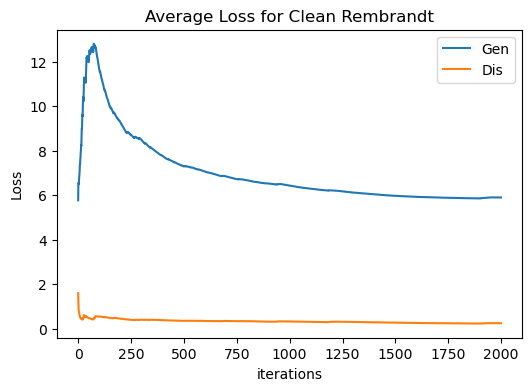

The mean average loss for the Discriminator and Generator was 0.3319 and 6.999


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(clean_G_loss_list,label="Gen")
plt.plot(clean_D_loss_list,label="Dis")
plt.title('Average Loss for Clean Rembrandt')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('The mean average loss for the Discriminator and Generator was {:.4} and {:.4}'.format(np.mean(clean_D_loss_list),np.mean(clean_G_loss_list)))

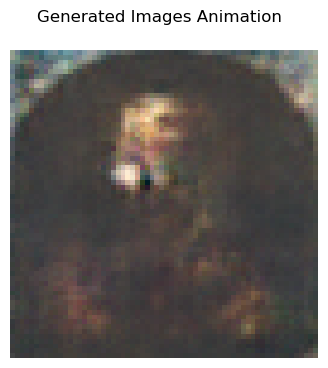

In [ ]:
#Generates a batch of images
with torch.no_grad():
    gen_img = clean_netG(fixed_noise_gen).detach().cpu()

fig = plt.figure(figsize=(4,4))
plt.axis("off")
clean_img_list = []
for i in range(64):
    clean_img_list.append(norm_img(gen_img[i]))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in clean_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

plt.suptitle('Generated Images Animation', fontsize=12)
HTML(ani.to_jshtml())

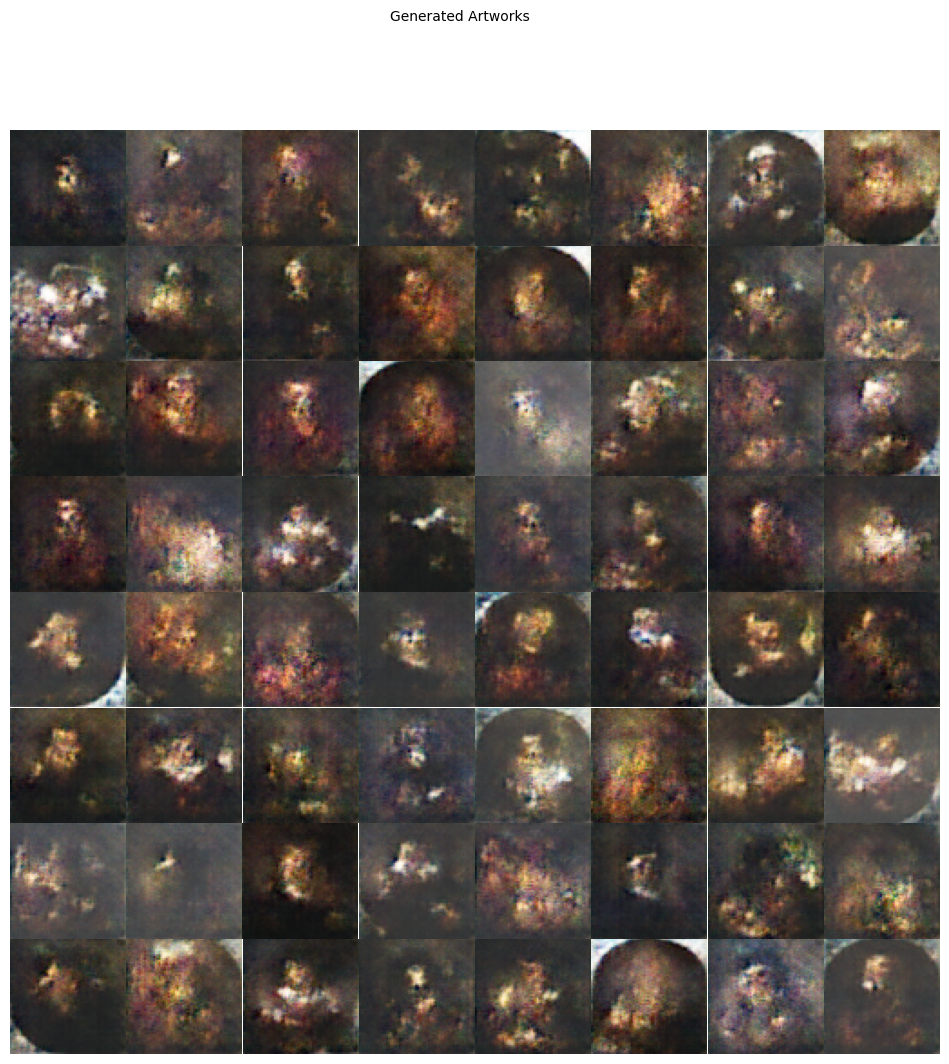

In [ ]:
plt.figure(figsize=(12,12))
ax_count = 1

for i in range(len(clean_img_list)):
    # Plot the fake images from the last epoch
    ax = plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(norm_img(clean_img_list[i]),(1,2,0)))

plt.suptitle('Generated Artworks', fontsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

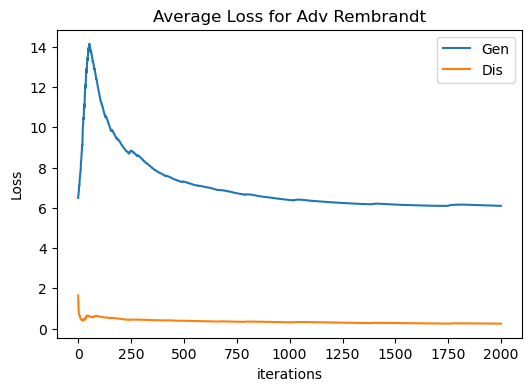

The mean average loss for the Discriminator and Generator was 0.3455 and 7.093


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(adv_G_loss_list,label="Gen")
plt.plot(adv_D_loss_list,label="Dis")
plt.title('Average Loss for Adv Rembrandt')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('The mean average loss for the Discriminator and Generator was {:.4} and {:.4}'.format(np.mean(adv_D_loss_list),np.mean(adv_G_loss_list)))

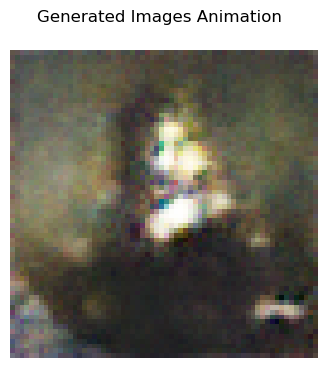

In [ ]:
#Generates a batch of images
with torch.no_grad():
    gen_img = adv_netG(fixed_noise_gen).detach().cpu()

fig = plt.figure(figsize=(4,4))
plt.axis("off")
adv_img_list = []
for i in range(64):
    adv_img_list.append(norm_img(gen_img[i]))

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in adv_img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

plt.suptitle('Generated Images Animation', fontsize=12)
HTML(ani.to_jshtml())

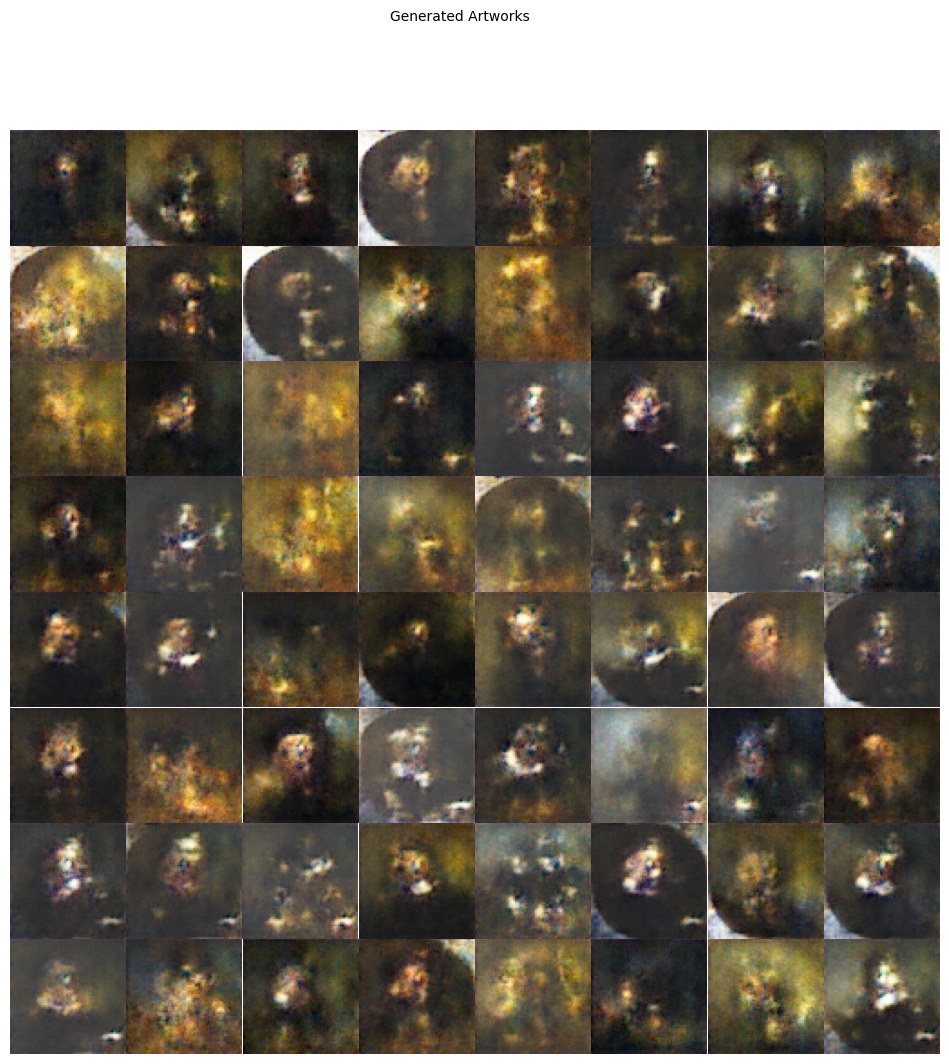

In [ ]:
plt.figure(figsize=(12,12))
ax_count = 1

for i in range(len(adv_img_list)):
    # Plot the fake images from the last epoch
    ax = plt.subplot(8,8,i+1)
    plt.axis("off")
    plt.imshow(np.transpose(norm_img(adv_img_list[i]),(1,2,0)))

plt.suptitle('Generated Artworks', fontsize=10)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
clean_gen_df = pd.DataFrame()
adv_gen_df = pd.DataFrame()

for i in range(len(clean_img_list)):
    t = np.array(torch.flatten(clean_img_list[i]))
    clean_gen_df[i] = t
    t = np.array(torch.flatten(adv_img_list[i]))
    adv_gen_df[i] = t

display(clean_gen_df)
display(adv_gen_df)

0         1         2         3         4         5         6   \
0      0.113814  0.337896  0.273879  0.199555  0.303985  0.235823  0.516735   
1      0.107561  0.340237  0.250958  0.187940  0.213727  0.234146  0.393583   
2      0.090144  0.314565  0.210963  0.170379  0.122539  0.213803  0.198584   
3      0.114059  0.316596  0.224560  0.185316  0.144640  0.224201  0.152394   
4      0.112434  0.337730  0.263989  0.183553  0.156099  0.247191  0.156611   
...         ...       ...       ...       ...       ...       ...       ...   
12283  0.118219  0.236120  0.192951  0.183288  0.159417  0.200301  0.194813   
12284  0.124888  0.231438  0.201049  0.178791  0.157632  0.186381  0.215178   
12285  0.167232  0.280650  0.258470  0.224196  0.183199  0.240497  0.265912   
12286  0.162842  0.289037  0.265757  0.241867  0.188953  0.251704  0.278099   
12287  0.164615  0.292757  0.284941  0.249778  0.186928  0.255084  0.297845   

             7         8         9   ...        54        55        56  \
0      0.413284  0.225426  0.230406  ...  0.204527  0.312357  0.185325   
1      0.399346  0.203033  0.229231  ...  0.192833  0.238282  0.173822   
2      0.350541  0.174501  0.209204  ...  0.160292  0.169290  0.146921   
3      0.352314  0.192616  0.225059  ...  0.185595  0.197015  0.167425   
4      0.430978  0.188606  0.230100  ...  0.190202  0.205878  0.171381   
...         ...       ...       ...  ...       ...       ...       ...   
12283  0.556987  0.183202  0.137084  ...  0.133034  0.221801  0.160015   
12284  0.537369  0.184384  0.129078  ...  0.132052  0.200282  0.168752   
12285  0.524038  0.219030  0.169890  ...  0.162519  0.265087  0.201171   
12286  0.525123  0.229654  0.178668  ...  0.177127  0.281020  0.199673   
12287  0.452631  0.228839  0.185275  ...  0.174559  0.288649  0.201313   

             57        58        59        60        61        62        63  
0      0.370095  0.122899  0.198092  0.161597  0.883792  0.223927  0.567968  
1      0.365762  0.112326  0.191176  0.151435  0.835725  0.226431  0.433961  
2      0.325974  0.091965  0.172204  0.136073  0.718733  0.209744  0.257298  
3      0.334411  0.114987  0.185874  0.146503  0.613468  0.234650  0.237866  
4      0.398010  0.109023  0.185369  0.133522  0.658945  0.227737  0.262650  
...         ...       ...       ...       ...       ...       ...       ...  
12283  0.190191  0.262728  0.176996  0.161945  0.099629  0.184829  0.238551  
12284  0.185739  0.273433  0.180576  0.158616  0.105191  0.182343  0.247907  
12285  0.236126  0.302631  0.236590  0.187493  0.144207  0.224853  0.304232  
12286  0.240772  0.301605  0.248959  0.197164  0.152348  0.230565  0.321402  
12287  0.245149  0.297543  0.264133  0.198814  0.161523  0.240853  0.334016  

[12288 rows x 64 columns]

0         1         2         3         4         5         6   \
0      0.289234  0.318486  0.266745  0.957351  0.284070  0.256839  0.289224   
1      0.289460  0.336074  0.273372  0.978968  0.285263  0.240503  0.302128   
2      0.339405  0.373719  0.319480  0.974213  0.294551  0.237783  0.347036   
3      0.274806  0.344103  0.269711  0.950472  0.265624  0.217488  0.291869   
4      0.321669  0.401658  0.333239  0.943202  0.263928  0.199082  0.326346   
...         ...       ...       ...       ...       ...       ...       ...   
12283  0.096047  0.096189  0.115506  0.229275  0.109112  0.138273  0.073410   
12284  0.131805  0.103691  0.135811  0.233192  0.144833  0.156416  0.082813   
12285  0.101453  0.089780  0.109766  0.224551  0.123581  0.144731  0.069916   
12286  0.134732  0.103005  0.112782  0.237790  0.149021  0.161115  0.085850   
12287  0.158443  0.111541  0.151357  0.242593  0.157311  0.168041  0.084788   

             7         8         9   ...        54        55        56  \
0      0.309627  0.943146  0.378630  ...  0.377343  0.428193  0.364377   
1      0.309652  0.970452  0.349661  ...  0.383426  0.425998  0.359845   
2      0.343652  0.965518  0.324276  ...  0.413645  0.450590  0.375120   
3      0.274500  0.940198  0.269300  ...  0.348071  0.381777  0.354635   
4      0.320308  0.940651  0.252023  ...  0.386697  0.391845  0.370435   
...         ...       ...       ...  ...       ...       ...       ...   
12283  0.197741  0.236639  0.108345  ...  0.202127  0.207131  0.274394   
12284  0.243044  0.243614  0.121414  ...  0.212715  0.225821  0.295123   
12285  0.195554  0.217571  0.112250  ...  0.179682  0.206206  0.293055   
12286  0.182100  0.231220  0.137234  ...  0.172100  0.198278  0.260407   
12287  0.285180  0.244892  0.133774  ...  0.215392  0.218784  0.321764   

             57        58        59        60        61        62        63  
0      0.215180  0.185291  0.311547  0.444730  0.240952  0.505188  0.377288  
1      0.215876  0.185089  0.308341  0.456893  0.240378  0.531491  0.378365  
2      0.248198  0.224159  0.309843  0.482059  0.265754  0.566778  0.419288  
3      0.202733  0.166814  0.271502  0.429257  0.217909  0.480500  0.359387  
4      0.237726  0.205276  0.285197  0.457165  0.261224  0.530941  0.399322  
...         ...       ...       ...       ...       ...       ...       ...  
12283  0.182504  0.142660  0.173839  0.212831  0.117105  0.148277  0.208491  
12284  0.227770  0.166422  0.196513  0.236876  0.135683  0.154916  0.218451  
12285  0.182180  0.111859  0.156219  0.217895  0.105048  0.128354  0.216178  
12286  0.172076  0.107782  0.172416  0.241930  0.138581  0.139386  0.188872  
12287  0.243525  0.157632  0.201090  0.254648  0.144118  0.147546  0.239218  

[12288 rows x 64 columns]

In [ ]:
cosine_list = []
for i in clean_gen_df:
    cos = np.dot(clean_gen_df[i],adv_gen_df[i])/(np.linalg.norm(clean_gen_df[i])*np.linalg.norm(adv_gen_df[i]))
    cosine_list.append(cos)

In [ ]:
print(min(cosine_list))
print(max(cosine_list))
print(np.mean(cosine_list))

0.67728645
0.9425689
0.8387498


In [ ]:
def mse(x, y):
   diff = np.subtract(x, y)
   err = np.sum(diff**2)
   mse = err/len(x)
   return mse

mse_list = []
for i in clean_gen_df:
    x = clean_gen_df[i]
    y = adv_gen_df[i]
    mse_list.append(mse(x,y))

In [ ]:
print(min(mse_list))
print(max(mse_list))
print(np.mean(mse_list))

0.00774797610938549
0.07931055625279744
0.03753736779132548
